In [1]:
import networkx as nx
import random
from sklearn import metrics
from cdlib import algorithms
# from cdlib import evaluation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy import stats
import os
from tqdm import tqdm as tqdm
import pickle


from scipy.sparse.linalg import eigsh

ModuleNotFoundError: No module named 'cdlib'

In [ ]:
def duplex_network (G, l1, l2):
    
    G1 = G[l1].copy()
    G2 = G[l2].copy()
    
    ##delete common edges
    list_of_common_edges = []
    
    for e in G[l1].edges():
        if G[l2].has_edge(e[0], e[1]):
            list_of_common_edges.append([e[0], e[1]])
            
            
    print (len(list_of_common_edges))
    
    
    for e in list_of_common_edges:
        G1.remove_edge(e[0], e[1])
        G2.remove_edge(e[0], e[1])
        
    
    
    ##delete nodes with zero degree
    list_of_nodes = []
    for n in G1.nodes():
        if G1.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.remove_node(n)
        
    list_of_nodes = []
    for n in G2.nodes():
        if G2.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G2.remove_node(n)
            
    

    ##create union of nodes
    list_of_nodes = []
    for n in G1.nodes():
        list_of_nodes.append(n)
    for n in G2.nodes():
        list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.add_node(n)
        G2.add_node(n)
        
        
        

    return G1, G2


#######

def partial_information (G1, G2, frac):
    
    
#     print ('# option = ', option)
    
    ##training/test sets
    Etest = {}
    Etrain = {}
    
    for e in G1.edges():
        if random.random() < frac:
            Etrain[e] = 1
        else:
            Etest[e] = 1
            
    for e in G2.edges():
        if random.random() < frac:
            Etrain[e] = 0
        else:
            Etest[e] = 0
        
        
    
    ##remnants
    rem_G1 = nx.Graph()
    rem_G2 = nx.Graph()
    for n in G1:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
    for n in G2:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
        
        
    
    for e in Etest:
        rem_G1.add_edge(e[0], e[1])
        rem_G2.add_edge(e[0], e[1])
            
    
    for e in Etrain:
        if Etrain[e] == 1:
            rem_G1.add_edge(e[0], e[1])
        if Etrain[e] == 0:
            rem_G2.add_edge(e[0], e[1])
    
    
    return rem_G1, rem_G2, Etest 


#####









def community_finder (G):
    
    C = algorithms.louvain(G)
#     C = algorithms.label_propagation(G)
    sigma = {}
    c = 0
    for r in C.communities:
        for q in r:
            sigma[q] = c
        c = c + 1
        
    mu = tot = 0.0
    for n in G.nodes():
        for m in G.neighbors(n):
            tot += 1.0
            if sigma[n] == sigma[m]:
                mu += 1.0
            
        
    return sigma, mu, tot





def classifier (rem_G1, rem_G2, Etest, TT = 0, show_log = False):
    
    ## degree/community
    if TT == 0:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)
        
        
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)


        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
                
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                
            if show_log == True: 
                print (mu)
                print (rem_G1.degree(n), rem_G1.degree(m), t1)
                print (rem_G2.degree(n), rem_G2.degree(m), t2)
                print (Etest[e], '\n')
                
                
            
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
    
        return classification, scores, ground_truth
    
    
    ## degree
    if TT == 1:
        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = rem_G1.degree(n)*rem_G1.degree(m)    
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                   
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
        return classification, scores, ground_truth
    
        
        
        
    ## community
    if TT == 2:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)
        
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)
        
        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = 1.0
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
                
            s2 = 1.0
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                
                
            
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
    
        return classification, scores, ground_truth
    
        
        
    
####


def perform_analysis (G1, G2, step, TT = 0):
    
    
    #print ('# option = ', option)
    
    
    x , y, z  = [], [], []
    
    
    frac = 0.0
    while frac < 1.0:
        
        if frac <= 1.0 - step:
            
            print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))
            
            rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)
            classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT)
            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)
            
            
            
            x.append(frac)
            y.append(acc)
            z.append(auc)
            
            
        frac += step
        
        
    results = [x, y, z]
    return results



In [ ]:
def classifier_LE (rem_G1, rem_G2, Etest, Kgroups, show_log = False):
    
   
    node_list = sorted(rem_G1.nodes())
    

    
    nL1 = nx.normalized_laplacian_matrix(rem_G1, nodelist=node_list)
    nL2 = nx.normalized_laplacian_matrix(rem_G2, nodelist=node_list)

    

    
#     print (rem_G1.edges())
#     print (nL1)
    
#     return 0
    
    
    eva1, eve1 = eigsh(nL1, k=Kgroups, which='SM')
    eva2, eve2 = eigsh(nL2, k=Kgroups, which='SM')
    
    
    
    classification, scores, ground_truth = [], [], []
    
    
    for e in Etest:
            
                
        n = e[0]
        m = e[1]
        
        d1 = d2 = 0.0
        ## the first eigencomponent is proportional to the node degree and is excluded in clustering
        for k in range(1, Kgroups):
            d1 += (eve1[n][k] - eve1[m][k])*(eve1[n][k] - eve1[m][k])
            d2 += (eve2[n][k] - eve2[m][k])*(eve2[n][k] - eve2[m][k])
        

        s1 = 1.0 / (d1 + 1e-60)
        s2 = 1.0 / (d2 + 1e-60)


        t1 = t2 = 0.5
        if s1 + s2 > 0.0:
            t1 = s1 / (s1 + s2)
            t2 = s2 / (s1 + s2)


        s = random.randint(0,1)
        if t1 > t2:
            s = 1
        if t2 > t1:
            s = 0

        if show_log == True: 
            print (d1, d2, t1)
            print (Etest[e], '\n')



        scores.append(t1)
        classification.append(s)
        ground_truth.append(Etest[e])



    return classification, scores, ground_truth

    
    
def perform_analysis_LE (G1, G2, step, Kgroups, show_log = False):
    
    
    #print ('# option = ', option)
    
    
    x , y, z  = [], [], []
    
    
    frac = 0.0
    while frac < 1.0:
        
        if frac <= 1.0 - step:
            
            print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))
            
            rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)
#             classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT)
            classification, scores, ground_truth = classifier_LE (rem_G1, rem_G2, Etest, Kgroups, show_log)
            
    
    
            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)
            
            
            
            x.append(frac)
            y.append(acc)
            z.append(auc)
            
            
        frac += step
        
        
    results = [x, y, z]
    return results

## Figure 2b

In [ ]:
def LFR(n,t1,t2,mu,avg_k,max_k):
    #function to generate LFR network as a networkx object and obtain community assignments
    N,Mu,T1,T2,maxk,k=str(n),str(mu),str(t1),str(t2),str(max_k),str(avg_k)
    s='./benchmark -N '+N+' -mu '+Mu+ ' -maxk ' +maxk  + ' -k '+k  +' -t1 ' +T1+' -t2 ' +T2
    os.system(s)
    
    x=np.loadtxt('network.dat')
    edges=[(int(x[i][0])-1,int(x[i][1])-1) for i in range(len(x))]
    g=nx.Graph(edges)
    
    x=np.loadtxt('community.dat')
    coms={int(x[i][0])-1:int(x[i][1]) for i in range(len(x))}
    #nx.set_node_attributes(g,coms,name='community')
    
    return g, coms




def lfr_multiplex (N, tau1, tau2, mu, average_degree, max_degree, min_community, prob_relabel):

                
    #############################        
            
    H, comm = LFR(n=N, t1=tau1, t2=tau2, mu=mu, avg_k=average_degree, max_k = max_degree)   
    groups = {}
    for n in comm:
        c = comm[n]
        if c not in groups:
            groups[c] = []
        groups[c].append(n)
        
   #############################   

    sigma1 = {}
    for n in comm:
        sigma1[n] = comm[n]

   #########
        
    
    new_labels = {}
    for C in groups:
        tmp = groups[C].copy()
        random.shuffle(tmp)
        for i in range(0, len(groups[C])):
            n = groups[C][i]
            m = tmp[i]
            new_labels[n] = m
    ###########################################  
    
    tmp_sigma2 = {}
    for n in sigma1:
        m = new_labels[n]
        tmp_sigma2[m] = sigma1[n]
        
    ###########################################
    
    
    
    
    G = {}
    G[1] = H.copy()
    G[2] = nx.Graph()
    for n in G[1]:
        G[2].add_node(n)
    for e in G[1].edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)
    ############################################
    
    
    
    
    
    
    #############################################
    ## break community correlation
    
    list_nodes = list(G[2].nodes())
    new_labels = {}
    H = G[2].copy()
    for n in G[2]:
        new_labels[n] = n
    for n in new_labels:
        if random.random()<prob_relabel:
            m = random.choice(list_nodes)
            tmp = new_labels[n]
            new_labels[n] = new_labels[m]
            new_labels[m] = tmp
            
    G[2] = nx.Graph()
    for n in H:
        m = new_labels[n]
        G[2].add_node(m)
    for e in H.edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)
    ##############################################
    
    
    sigma2 = {}
    for n in tmp_sigma2:
        m = new_labels[n]
        sigma2[m] = tmp_sigma2[n]
    
    
    
#     print(len(G[1].edges()))
#     print(len(G[2].edges()))
    
    
    
    return G, sigma1, sigma2, mu




In [ ]:
N = 10_000
tau2 = 1.0
mu = 0.1
average_degree = 6.0
min_community = 1
prob = 1.0


results_lfr = {}

In [ ]:
gamma = 2.1
max_degree = 100
step = 0.1
Kgroups = 128


G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[str(gamma)+'C'] = perform_analysis (G1, G2, step, TT=0)
results_lfr[gamma] = perform_analysis_LE (G1, G2, step, Kgroups, show_log = False)

9
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


(0.0, 1)

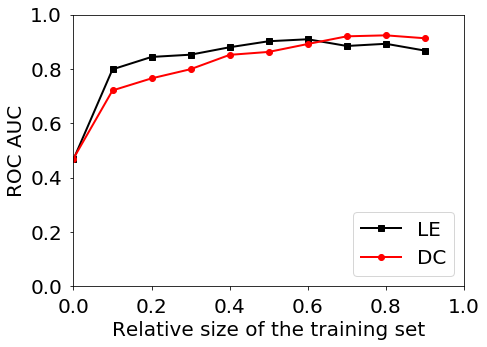

In [ ]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

gamma = 2.1
plt.plot(results_lfr[gamma][0], results_lfr[gamma][2], marker='s', linewidth=2, color = 'black', label='LE')


plt.plot(results_lfr[str(gamma)+'C'][0], results_lfr[str(gamma)+'C'][2], marker='o', linewidth=2, color = 'red', label='DC')



plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)